In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
from time import sleep
import math
from enum import Enum

In [67]:
fps = 25
spf = 0.04
# Draws an image given a figure, ax=fig.gca(), frame, and wait time
def draw_image_frame(fig, ax, frame, time=0.04):
    fig.clf()
    plt.imshow(frame, interpolation='None')
    fig.canvas.draw()
    sleep(time)
    
# Stores all scientific constants that would be used
class constant():
    G = 6.6748e-11 # Gravitational Constant units (m^3 kg^-1 s^-2)
    c = 299792458 # Speed of light units (m s^-1)
    c2 = constant.c*constant.c
    solarM = 2e30 # solar mass in kg
    solarR = 7e8 # solar radius in m
    sfieldConst = 2*G*solarM/(c*c*solarR)# Schwarldfield radius constant 2*G/c^2 * solarM/solarR units (solarR/solarM)

(1971, 3000, 3)


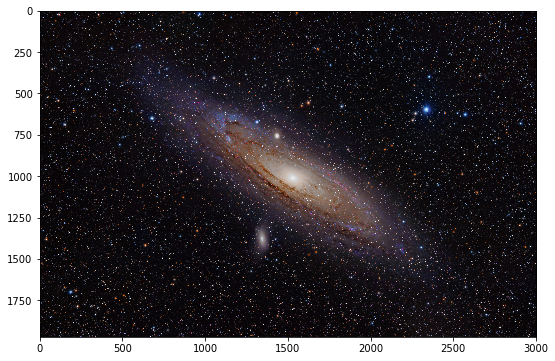

In [68]:
background = plt.imread("./images/andromeda.jpg")
#li_shape = load_image.shape

#image = np.empty((li_shape[0],li_shape[1],4))

#if len(li_shape) != 3 or li_shape[2] != 4:
#    for m in range(li_shape[0]):
#        for n in range(li_shape[1]):
#            image[m,n,0] = load_image[m,n,0]
#            image[m,n,1] = load_image[m,n,1]
#            image[m,n,2] = load_image[m,n,2]
#            image[m,n,3] = 1
#else:
#    image = load_image
print(background.shape)
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

draw_image_frame(fig, ax, background)

In [149]:
# Function to find the magnitude of a ray defined by 2 points
def magnitude(pt1, pt2):
    return np.sqrt(np.sum(np.square(pt1-pt2)))

#Location/center is a numpy array of size (3,1)
#Mass and raidus is in units of solar mass and solar radii

# Blackhole class which define the blackhole as a sphere
class blackhole:
    def __init__(self, mass, center, Dls, Dl, color=np.array([0,0,0])): 
        self.mass = mass              #Mass of the Blackhole in solar mass
        self.radius = 1.5*constant.sfieldConst*mass#Photon Sphere Radius of the Blackhole in solar radii
        self.Rs = constant.sfieldConst*mass #Schwarldshield Radius
        self.center = center          #Center coordinates of the Blackhole
        self.radius2 = self.radius*self.radius  #Square of the radius (Help to reduce computation)
        self.Dls = Dls                #Distance to the observer
        self.Dl = Dl                  #Distance to blackground image
        self.Ds = Dl+Dls              #Distance from observer to image
        self.normal=np.array([0,0,1]) #Normal vector for the plane which the blackhole resides
        self.color=color              #The Color of the blackhole as seen on the image. White by default to make it obvious
        
        #Angular size of Einstein ring
        self.angularSize = np.sqrt(2*constant.sfieldConst*mass*Dls/(Dl*(Dl+Dls)))
        #The Einstein radius as computed using the angular size of Einstein ring
        self.lens_radius = self.radius+np.tan(self.angularSize)*Dls#np.tan(self.angularSize)*Dls
        
    # Find the intersection between the between a ray and blackhole
    # If there is an intersection 
    #     returns (number of intersections, point/s of intersection)
    # else
    #     return None
    def intersect(self, ray):
        oc = (ray.origin - self.center)
        a = np.dot(ray.direction, ray.direction)
        b = 2*np.dot(oc, ray.direction)
        c = np.dot(oc,oc) - self.radius2
        
        b2 = b*b
        ac4 = 4*a*c
        if b2 > ac4:
            sq = np.sqrt(b*b - ac4)
            demon = 2*a
            return self.color
            #return 2, ray.traverse((-b + sq)/(demon)), ray.traverse((-b - sq)/(demon))
        elif b2 == ac4:
            return self.color
            #return 1, ray.traverse(-b/(2*a))
        else:
            return None
        
    # Find the pixel value for a ray that have been refracted by a lens
    # If there is an intersection
    #    return pixel value on background image
    # else
    #     return None
    #Lens_type references the type of lens
    #True: a true lens where the center is transparent
    #Ring: len-like only on the edges and opaque at Schwarldfield radius
    def intersect_lens(self, rayIn, BGimage, lens_type='True'):
        if lens_type == 'True':
            t = np.dot(self.center-rayIn.origin, self.normal)/np.dot(rayIn.direction, self.normal)
            plane_point = rayIn.traverse(t)
            
            if magnitude(plane_point, self.center) < self.lens_radius:
                newray = ray(plane_point, np.array([0,0,self.center[2]+self.Dl]))
                return BGimage.intersect(newray)
            else:
                return None
            
            #return self.intersect(ray)
        elif lens_type == 'Ring':
            t = np.dot(self.center-rayIn.origin, self.normal)/np.dot(rayIn.direction, self.normal)
            plane_point = rayIn.traverse(t)
            
            mag = magnitude(plane_point, self.center)
            if mag < self.lens_radius:
                if mag > self.radius:
                    newray = ray(plane_point, np.array([0,0,self.center[2]+self.Dl]))
                    return BGimage.intersect(newray)
                else:
                    return self.color
            else:
                return None
        else:
            print(lens_type, ' is not a proper lens type')
            sys.exit()
            
    def intersect_real(self, rayIn, BGimage):
        t = np.dot(self.center-rayIn.origin, self.normal)/np.dot(rayIn.direction, self.normal)
        plane_point = rayIn.traverse(t)

        b = magnitude(plane_point, self.center) #imapact parameter
        if b < self.lens_radius:
            if b > self.radius:
                alpha = 2*self.Rs/b
                radial = plane_point-self.center
                radial = radial/np.linalg.norm(radial)
                direc = rayIn.direction/np.linalg.norm(rayIn.direction)
                
                newdirec = np.cos(alpha)*direc + np.sin(alpha)*radial
                
                newray = ray(plane_point, newdirec, dirCondition=True)
                return BGimage.intersect(newray)
            else:
                return self.color
        else:
            return None
        
        
# Background image class which is represented by a plane 
class background_image:
    def __init__(self, image, center): 
        self.center = center            #center index of the image
        self.image = image
        self.shape = image.shape
        self.normal = np.array([0,0,1])
        
    # Compute the intersection between the ray the background image plane
    # If there isn't an intersection None is return
    def intersect(self, ray):
        t = np.dot(np.array([0,0,self.center[2]])-ray.origin, self.normal)/np.dot(ray.direction, self.normal)
        plane_point = ray.traverse(t)
        within_x = plane_point[0] > -(self.center[0]) and plane_point[0] < self.shape[1]-self.center[0]-1
        within_y = plane_point[1] > -(self.center[1]) and plane_point[1] < self.shape[0]-self.center[1]-1
        if within_x and within_y:
            return self.image[(self.center[1]+plane_point[1]).astype(int), (self.center[0]-plane_point[0]).astype(int)]
        else:
            return None
        
    #Compute the intersection and returning the interesection. Doesn't check.
    def intersect_pixel(self, ray):
        t = np.dot(np.array([0,0,self.center[2]])-ray.origin, self.normal)/np.dot(ray.direction, self.normal)
        plane_point = ray.traverse(t)
        return self.image[(self.center[1]+plane_point[1]).astype(int), (self.center[0]-plane_point[0]).astype(int)]
        
        
# Ray class defined as the ray's origin and direction vector
# ray = o + dt
class ray:
    def __init__(self, origin, pixel, dirCondition=False):
        self.origin = origin
        if dirCondition:
            self.direction = pixel
        else:
            self.direction = pixel - origin
        
    def __str__(self):
        return str(self.origin) + ' + ' + str(self.direction) + 't'
        
    def __repr__(self):
        return repr(self.origin) + ' + ' + repr(self.direction) + 't'
    
    #Compute the point for the ray given a t value
    def traverse(self, t):
        return self.origin + self.direction*t
        
        
    

## Main Code

In [155]:
#Camera is located in the postitive z axis and looking in the negative z direction
#z-coordinates of each elements
camera_zcoord = 100
image_zcoord = 0
BH_zcoord = -10
BGimage_zcoord = -200

#Location at what the observer is located
camera_origin = np.array([0, 0, camera_zcoord])

#Settings for the Black Hole located between the observer and background
BHmass = 6000000
BH_loc = np.array([0, 0, BH_zcoord])
BH = blackhole(BHmass, BH_loc, camera_zcoord-BH_zcoord, BH_zcoord-BGimage_zcoord)

#The image that is going to be rendered
image = np.empty((201,201,3))
image_shape = image.shape
image_center = np.array([math.ceil(image_shape[1]/2), math.ceil(image_shape[0]/2)])

#The background image that is going to be located behind the black hole
BGimage = background_image(background, np.array([background.shape[1]//2, background.shape[0]//2, BGimage_zcoord]))


[ 4309 36092     0]
[   0 4309]


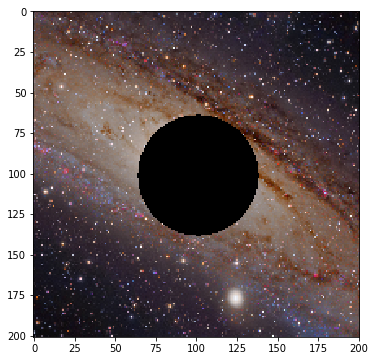

In [156]:
# Rendering of the Blackhole as just a obaque object.
# A test case to ensure that the ray tracing code is working

# The difference usages of each case:
# Case 1: intersect with black hole
# Case 2: Intersect with background image
# Case 3: Intersect with nothing
usages = np.array([0,0,0])
# The different intersections with a sphere
# Case 1: 1 Intersection Point
# Case 2: 2 Intersections Points
sphere_usages = np.array([0,0])
for height in range(image_shape[0]):
    for width in range(image_shape[1]):
        r = ray(camera_origin, np.array([width-image_center[0], image_center[1]-height, image_zcoord]))
        
        BHintersect = BH.intersect(r)
        if BHintersect is not None:
            image[height, width] = BHintersect
            usages[0] += 1
            if BHintersect[0] == 1:
                sphere_usages[0] += 1
            else:
                sphere_usages[1] += 1
            
        else:
            BGintersect = BGimage.intersect(r)
            if BGintersect is not None:
                image[height, width] = BGintersect
                usages[1] += 1
        
            else:
                image[height, width] = np.array([0,0,0])
                usages[2] += 1


image = image.astype(int)
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

draw_image_frame(fig, ax, image)
print(usages)
print(sphere_usages)

[14169 26232     0]


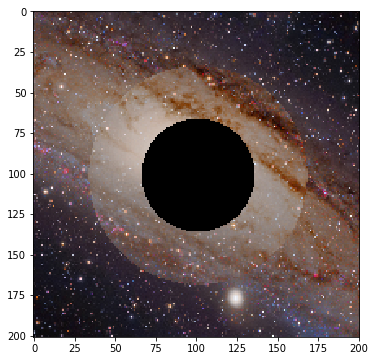

In [ ]:
# Rendering of the Blackhole 
# as a lens with distance equal to angular size of the Eistien ring

# The difference usages of each case:
# Case 1: under the influence of 
# Case 2: Intersect with background image
# Case 3: Intersect with nothing
usages = np.array([0,0,0])

for height in range(image_shape[0]):
    for width in range(image_shape[1]):
        r = ray(camera_origin, np.array([width-image_center[0], image_center[1]-height, image_zcoord]))
        
        BHintersect = BH.intersect_lens(r, BGimage, 'Ring')
        if BHintersect is not None:
            image[height, width] = BHintersect
            usages[0] += 1
            
        else:
            BGintersect = BGimage.intersect(r)
            if BGintersect is not None:
                image[height, width] = BGintersect
                usages[1] += 1
        
            else:
                image[height, width] = np.array([0,0,0])
                usages[2] += 1


image = image.astype(int)
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

draw_image_frame(fig, ax, image)
print(usages)

In [ ]:
# Rendering of the Blackhole 
# as a lens with distance equal to angular size of the Eistien ring

# The difference usages of each case:
# Case 1: under the influence of 
# Case 2: Intersect with background image
# Case 3: Intersect with nothing
usages = np.array([0,0,0])

for height in range(image_shape[0]):
    for width in range(image_shape[1]):
        r = ray(camera_origin, np.array([width-image_center[0], image_center[1]-height, image_zcoord]))
        
        BHintersect = BH.intersect_real(r, BGimage)
        if BHintersect is not None:
            image[height, width] = BHintersect
            usages[0] += 1
            
        else:
            BGintersect = BGimage.intersect(r)
            if BGintersect is not None:
                image[height, width] = BGintersect
                usages[1] += 1
        
            else:
                image[height, width] = np.array([0,0,0])
                usages[2] += 1


image = image.astype(int)
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

draw_image_frame(fig, ax, image)
print(usages)

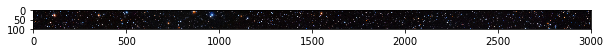

In [154]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

#print(background[:10, :10])

draw_image_frame(fig, ax, background[0:100, :])

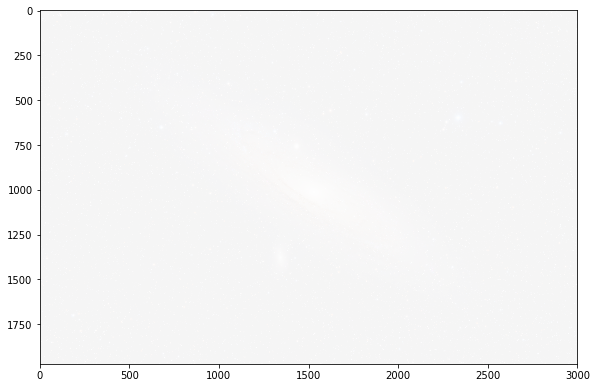

In [47]:
fig = plt.figure(figsize=(10,6.5))
ax = fig.gca()

a = 1.0

for i in range(25):
    fig.clf()
    plt.imshow(image, interpolation='None', alpha=a)
    a = a - 0.04
    fig.canvas.draw()
    sleep(0.04)

In [ ]:
plt.imshow(image, interpolation='None', alpha=0.5)

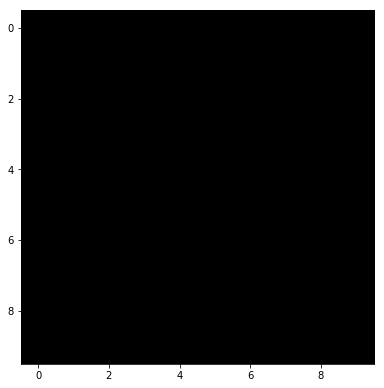

In [61]:
frame_dimensions = (10,10)

frame = np.zeros((frame_dimensions[0], frame_dimensions[0],3))

fig = plt.figure(figsize=(10,6.5))
ax = fig.gca()

draw_image_frame(fig, ax, frame, time=1)

In [2]:
G= 6.6748e-11

In [5]:
print(G*100000000000)

6.674799999999999
